[Table of Contents](./table_of_contents.ipynb)

# 粒子フィルタ

In [1]:
%matplotlib inline

In [5]:
#format the book
import book_format
book_format.set_style()

## 動機


* **多峰性 (マルチモーダル)**: ゼロ個、一つ、あるいは複数の物体を同時に追跡したい。

* **遮蔽 (オクルージョン)**: 物体が他の物体を隠し、複数のオブジェクトから観測値が一つしか得られない場合がある。

* **非線形な挙動**: 飛行機は風にあおられ、球は放物線を描いて動き、人は互いにぶつかり合う。

* **非線形な観測値**: レーダーは物体への距離を観測するので、(x,y,z) の座標に変換するとき非線形な平方根が必要になる。

* **ガウス分布に従わないノイズ:** 背景が大きく変化すると、コンピュータービジョンのアルゴリズムが背景を物体と誤認する場合がある。

* **連続:** 物体の位置と速度 (つまり状態) は時間の経過とともに滑らかに変化する。

* **多変量**: 位置、速度、旋回速度といった複数の属性を追跡したい。

* **未知のプロセスモデル**: 系のプロセスモデルを私たちは知らない。

以下のフィルタはどれも、上記の制約があるとき上手く動作しない。

* **離散ベイズフィルタ**: 最も多くの制約に対応可。多峰性、非線形な観測値・振る舞いに対応可。しかし、離散的かつ単変量

* **カルマンフィルタ**: ガウス分布に従うノイズを持った単峰性の線形系に対して最適な推定値を生成する。どの制約も対応不可。

* **無香料カルマンフィルタ**: 非線形、連続、多変量の問題に対応可。しかし、多峰性でなく、遮蔽の対応不可。

* **拡張カルマンフィルタ**: ガウス分布に従わないノイズと非線形性からの影響を受けやすい。

## 一般的な粒子フィルタアルゴリズム

1. **粒子の生成**
    
2. **予測**

3. **更新**

4. **再サンプリング**

5. **推定値の計算**



In [10]:
import kf_book.pf_internal as pf_internal

In [13]:
pf_internal??

Type:        module
String form: <module 'kf_book.pf_internal' from '/home/shogo/Documents/Jupyter Notebook/Kalman-and-Bayesian-Filters-in-Python/kf_book/pf_internal.py'>
File:        ~/Documents/Jupyter Notebook/Kalman-and-Bayesian-Filters-in-Python/kf_book/pf_internal.py
Source:     
# -*- coding: utf-8 -*-

"""Copyright 2015 Roger R Labbe Jr.


Code supporting the book

Kalman and Bayesian Filters in Python
https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python


This is licensed under an MIT license. See the LICENSE.txt file
for more information.
"""

from __future__ import (absolute_import, division, print_function,
                        unicode_literals)


import warnings

from filterpy.monte_carlo import stratified_resample, residual_resample
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
from numpy.random import randn, random, uniform, multivariate_normal, seed
import scipy.stats



class ParticleFilter(object):

    def __init__(self, N

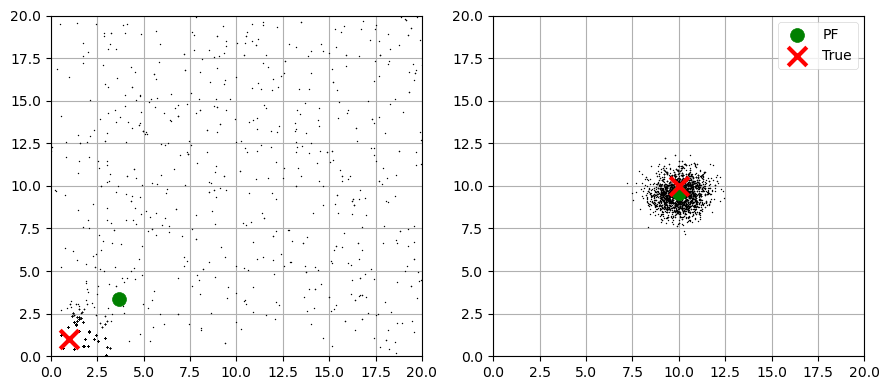

In [14]:
pf_internal.show_two_pf_plots()

If you are viewing this in a browser, this animation shows the entire sequence:

<img src='animations/particle_filter_anim.gif'>

We can use Monte Carlo methods to compute any integral. The PDF is computed with an integral, hence we can compute the PDF of this curve using Monte Carlo. 

## 粒子フィルタ

一様分布およびガウス分布に従う粒子を特定の領域に生成するコード

In [15]:
from numpy.random import uniform

def create_uniform_particles(x_range, y_range, hdg_range, N):
    particles = np.empty((N, 3))
    particles[:, 0] = uniform(x_range[0], x_range[1], size=N)
    particles[:, 1] = uniform(y_range[0], y_range[1], size=N)
    particles[:, 2] = uniform(hdg_range[0], hdg_range[1], size=N)
    particles[:, 2] %= 2 * np.pi
    return particles

def create_gaussian_particles(mean, std, N):
    particles = np.empty((N, 3))
    particles[:, 0] = mean[0] + (randn(N) * std[0])
    particles[:, 1] = mean[1] + (randn(N) * std[1])
    particles[:, 2] = mean[2] + (randn(N) * std[2])
    particles[:, 2] %= 2 * np.pi
    return particles

使用例:

In [9]:
create_uniform_particles((0,1), (0,1), (0, np.pi*2), 4)

array([[0.772, 0.336, 4.171],
       [0.333, 0.34 , 4.319],
       [0.6  , 0.274, 5.02 ],
       [0.054, 0.022, 5.034]])

### 予測ステップ

In [16]:
def predict(particles, u, std, dt=1.):
    """ move according to control input u (heading change, velocity)
    with noise Q (std heading change, std velocity)`"""

    N = len(particles)
    # update heading
    particles[:, 2] += u[0] + (randn(N) * std[0])
    particles[:, 2] %= 2 * np.pi

    # move in the (noisy) commanded direction
    dist = (u[1] * dt) + (randn(N) * std[1])
    particles[:, 0] += np.cos(particles[:, 2]) * dist
    particles[:, 1] += np.sin(particles[:, 2]) * dist

### 更新ステップ


```python
def update(likelihood, prior):
    posterior = prior * likelihood
    return normalize(posterior)
```

このコードは次の式を実装する

$$x = \| \mathcal L \bar x \|$$

そしてこの式はベイズの定理の式に具体的な値を代入したものである:

$$\begin{aligned}P(x \mid z) &= \frac{P(z \mid x)\, P(x)}{P(z)} \\
 &= \frac{\mathtt{尤度}\times \mathtt{事前分布}}{\mathtt{正規化係数}}\end{aligned}$$

In [11]:
def update(particles, weights, z, R, landmarks):
    for i, landmark in enumerate(landmarks):
        distance = np.linalg.norm(particles[:, 0:2] - landmark, axis=1)
        weights *= scipy.stats.norm(distance, R).pdf(z[i])

    weights += 1.e-300      # avoid round-off to zero
    weights /= sum(weights) # normalize

### 状態推定値の計算

追跡する物体が一つ (フィルタは単峰性) と仮定すると、粒子の集まりが表す推定値は位置の重み付き平均として計算できる:

$$\displaystyle \mu = \frac{1}{N}\sum_{i=1}^N w^ix^i$$

ここで $x^i$ は $\mathtt{i}$ 番目の粒子の位置. 例えば、時刻　$\mathtt{k+1}$ における i 番目の粒子の位置は  $x^i_{k+1}$. 

共分散行列も同様に計算できる。次の関数は粒子の平均と分散を計算する:

In [12]:
def estimate(particles, weights):
    """returns mean and variance of the weighted particles"""

    pos = particles[:, 0:2]
    mean = np.average(pos, weights=weights, axis=0)
    var  = np.average((pos - mean)**2, weights=weights, axis=0)
    return mean, var

一辺の長さが 1 の正方形の中に等しい重みを持った点を一様ランダムに生成すると、その平均は正方形の中心に近く、分散は小さいはずである。

In [13]:
particles = create_uniform_particles((0,1), (0,1), (0, 5), 1000)
weights = np.array([.25]*1000)
estimate(particles, weights)

(array([0.494, 0.514]), array([0.083, 0.085]))

### 粒子の再サンプリング

In [14]:
def simple_resample(particles, weights):
    N = len(particles)
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1. # avoid round-off error
    indexes = np.searchsorted(cumulative_sum, random(N))

    # resample according to indexes
    particles[:] = particles[indexes]
    weights.fill(1.0 / N)


$$\hat{N}_\text{eff} = \frac{1}{\sum w^2}$$



In [15]:
def neff(weights):
    return 1. / np.sum(np.square(weights))

## SIR フィルタ（サンプリング-重み付け-再サンプリングフィルタ）

In [16]:
def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights.resize(len(particles))
    weights.fill (1.0 / len(weights))

final position error, variance:
	 [-0.106  0.106] [0.009 0.008]


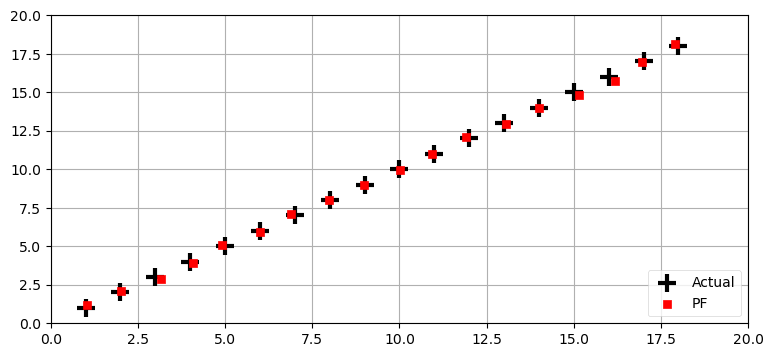

In [17]:
from filterpy.monte_carlo import systematic_resample
from numpy.linalg import norm
from numpy.random import randn
import scipy.stats

def run_pf1(N, iters=18, sensor_std_err=.1, 
            do_plot=True, plot_particles=False,
            xlim=(0, 20), ylim=(0, 20),
            initial_x=None):
    landmarks = np.array([[-1, 2], [5, 10], [12,14], [18,21]])
    NL = len(landmarks)
    
    plt.figure()
   
    # create particles and weights
    if initial_x is not None:
        particles = create_gaussian_particles(
            mean=initial_x, std=(5, 5, np.pi/4), N=N)
    else:
        particles = create_uniform_particles((0,20), (0,20), (0, 6.28), N)
    weights = np.ones(N) / N

    if plot_particles:
        alpha = .20
        if N > 5000:
            alpha *= np.sqrt(5000)/np.sqrt(N)           
        plt.scatter(particles[:, 0], particles[:, 1], 
                    alpha=alpha, color='g')
    
    xs = []
    robot_pos = np.array([0., 0.])
    for x in range(iters):
        robot_pos += (1, 1)

        # distance from robot to each landmark
        zs = (norm(landmarks - robot_pos, axis=1) + 
              (randn(NL) * sensor_std_err))

        # move diagonally forward to (x+1, x+1)
        predict(particles, u=(0.00, 1.414), std=(.2, .05))
        
        # incorporate measurements
        update(particles, weights, z=zs, R=sensor_std_err, 
               landmarks=landmarks)
        
        # resample if too few effective particles
        if neff(weights) < N/2:
            indexes = systematic_resample(weights)
            resample_from_index(particles, weights, indexes)
            assert np.allclose(weights, 1/N)
        mu, var = estimate(particles, weights)
        xs.append(mu)

        if plot_particles:
            plt.scatter(particles[:, 0], particles[:, 1], 
                        color='k', marker=',', s=1)
        p1 = plt.scatter(robot_pos[0], robot_pos[1], marker='+',
                         color='k', s=180, lw=3)
        p2 = plt.scatter(mu[0], mu[1], marker='s', color='r')
    
    xs = np.array(xs)
    #plt.plot(xs[:, 0], xs[:, 1])
    plt.legend([p1, p2], ['Actual', 'PF'], loc=4, numpoints=1)
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    print('final position error, variance:\n\t', mu - np.array([iters, iters]), var)
    plt.show()

from numpy.random import seed
seed(2) 
run_pf1(N=5000, plot_particles=False)

final position error, variance:
	 [-0.019 -0.005] [0.005 0.006]


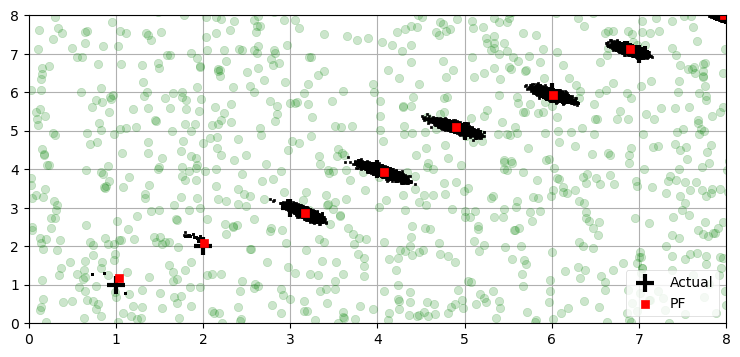

In [18]:
seed(2)
run_pf1(N=5000, iters=8, plot_particles=True, 
        xlim=(0,8), ylim=(0,8))

final position error, variance:
	 [-0.17   0.084] [0.005 0.005]


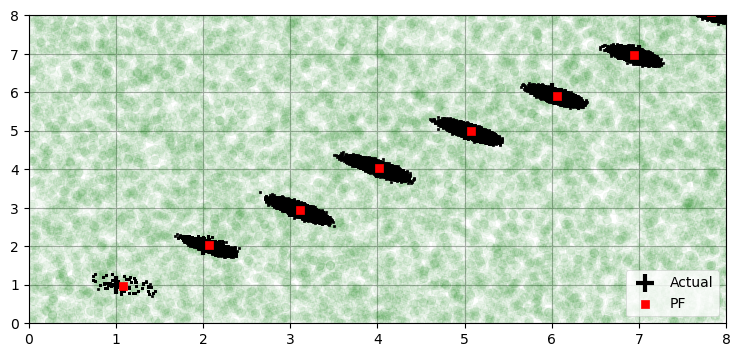

In [19]:
seed(2) 
run_pf1(N=100000, iters=8, plot_particles=True, 
        xlim=(0,8), ylim=(0,8))